unet是一个图像分割网络，论文是U-Net: Convolutional Networks for Biomedical Image Segmentation。它在ISBI 2015的细胞跟踪挑战中取得了最好的成绩，因此很有研究的价值。

# 挂载网盘和准备数据


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r /content/drive/My\ Drive/unet-data ./

# 数据扩展
ISBI挑战是关于医学图像方面的，因此能够取得的训练数据集有限，这个时候，适当的进行数据扩展操作，可让我们的训练结果更可靠。keras中提供了现有的图像扩展函数:
keras.preprocessing.image.ImageDataGenerator(),它的参数有很多，可以查看[keras documentation ](https://keras.io/preprocessing/image/),这里还有篇中文介绍[Keras花式工具箱](https://zhuanlan.zhihu.com/p/30197320)。下面我们用这个工具来扩展现有的医学图像,需要注意的是原始图像和它对应的分割图像应该具有相同的变换参数，这个可以通过相同的seed参数来实现

In [0]:
from keras.preprocessing.image import ImageDataGenerator
def train_augmentation(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (512,512),seed = 11):
  image_datagen = ImageDataGenerator(**aug_dict)
  mask_datagen = ImageDataGenerator(**aug_dict)
  image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
  mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
  train_generator = zip(image_generator, mask_generator)
  for (img,mask) in train_generator:
    yield (img,mask)
#利用上面的函数我们产生10倍的扩展数据
data_gen_args = dict(rotation_range=1,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGenerator = train_augmentation(20,'unet-data/train','image','label',data_gen_args,save_to_dir = "unet-data/train/aug")
num_batch = 10
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

有了训练用数据，我们接下来看看unet网络的具体结构，这里直接放论文中的网络结构图：
![unet网络](https://i.ibb.co/P4Qhgms/Snipaste-2019-09-27-19-33-13.png)

这里的所有卷积操作都不需要填充，然后up-conv操作是先一个对feature map上采样，然后接一个2*2的卷积网络，在卷积网络中降低一半的通道数。这里我们先用keras实现这个网络

In [0]:
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
import keras
import keras.backend as K
import tensorflow as tf
from functools import partial
import sys

def custom_loss(weights):
  def w_loss(y_true, y_pred):
    batch_loss=tf.where(y_true>0,tf.log(y_pred),y_true)
    weighted_loss=-tf.multiply(weights,batch_loss)
    return K.mean(K.sum(weighted_loss,axis=[1,2,3]))
  return w_loss

def unet(pretrained_weights = None,is_train=False,input_size = (572,572,1),weight_size=(388,388,2)):
  inputs = Input(input_size)
  conv1=Conv2D(64,3,activation='relu',kernel_initializer='he_normal')(inputs)
  conv1=Conv2D(64,3,activation='relu',kernel_initializer='he_normal')(conv1)
  pool1=MaxPooling2D(pool_size=(2,2))(conv1)
  conv2=Conv2D(128,3,activation='relu',kernel_initializer='he_normal')(pool1)
  conv2=Conv2D(128,3,activation='relu',kernel_initializer='he_normal')(conv2)
  pool2=MaxPooling2D(pool_size=(2,2))(conv2)
  conv3=Conv2D(256,3,activation='relu',kernel_initializer='he_normal')(pool2)
  conv3=Conv2D(256,3,activation='relu',kernel_initializer='he_normal')(conv3)
  pool3=MaxPooling2D(pool_size=(2,2))(conv3)
  conv4=Conv2D(512,3,activation='relu',kernel_initializer='he_normal')(pool3)
  conv4=Conv2D(512,3,activation='relu',kernel_initializer='he_normal')(conv4)
  pool4=MaxPooling2D(pool_size=(2,2))(conv4)
  conv5=Conv2D(1024,3,activation='relu',kernel_initializer='he_normal')(pool4)
  conv5=Conv2D(1024,3,activation='relu',kernel_initializer='he_normal')(conv5)
  up6=Conv2D(512,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv5))
  crop4=Cropping2D((4,4))(conv4)
  merge6=concatenate([crop4,up6],axis=3)
  conv6=Conv2D(512,3,activation='relu',kernel_initializer='he_normal')(merge6)
  conv6=Conv2D(512,3,activation='relu',kernel_initializer='he_normal')(conv6)
  up7=Conv2D(256,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
  crop3=Cropping2D((16,16))(conv3)
  merge7=concatenate([crop3,up7],axis=3)
  conv7=Conv2D(256,3,activation='relu',kernel_initializer='he_normal')(merge7)
  conv7=Conv2D(256,3,activation='relu',kernel_initializer='he_normal')(conv7)
  up8=Conv2D(512,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
  crop2=Cropping2D((40,40))(conv2)
  merge8=concatenate([crop2,up8],axis=3)
  conv8=Conv2D(128,3,activation='relu',kernel_initializer='he_normal')(merge8)
  conv8=Conv2D(128,3,activation='relu',kernel_initializer='he_normal')(conv8)
  up9=Conv2D(64,2,activation='relu',padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
  crop1=Cropping2D((88,88))(conv1)
  merge9=concatenate([crop1,up9],axis=3)
  conv9=Conv2D(64,3,activation='relu',kernel_initializer='he_normal')(merge9)
  conv9=Conv2D(64,3,activation='relu',kernel_initializer='he_normal')(conv9)
  conv10 = Conv2D(2, 1, activation = 'relu',kernel_initializer='he_normal')(conv9)
  out_softmax=Softmax()(conv10)
  if is_train:
    input_weights=Input(weight_size)
    model = Model(inputs = [inputs,input_weights], outputs = out_softmax)
    wloss = custom_loss(weights=input_weights)
    model.compile(optimizer = Adam(lr = 1e-4), loss = wloss, metrics = ['categorical_accuracy'])
  else:
    model = Model(inputs = inputs, outputs = out_softmax)
  #model.summary()
  if(pretrained_weights):
    model.load_weights(pretrained_weights)
  return model

上面定义的unet网络结构中，我们不仅需要训练用输入图片，而且还需要权重weight输入，那么这个权重是怎么计算的呢？首先，细胞和细胞壁出现概率是不一样的，那么我们需要为这两类像素点，分配不同的权重，以平衡这个概率。,然后论文中为了加强对邻近细胞边界的识别，对这部分边界数据的权重进行了增加，使用的公式是:
$$
w(x)=w_c(x)+w_0\cdot exp(-\frac{(d_1(x)+d_2(x))^2}{2\sigma^2})
$$
这里的$w_c$是上面我们计算出的相应类别的权重，然后$d_1$表示$x$到最近细胞的距离，$d_2$表示$x$到第二近的细胞的距离，然后$w_0=10,\sigma \approx 5$。下面对每一个mask图像，我们来计算对应的权重:

In [0]:
import numpy as np
import os
from skimage import io
from skimage import measure
from scipy.ndimage.morphology import distance_transform_edt


def unet_wmap(mask_img,w0=10.0,sigma=5):
  denominator=2*sigma*sigma
  cell_wall_num=(mask_img<255/2).sum()
  cell_num=mask_img.size-cell_wall_num
  weights=np.asarray([1.0/cell_num,1.0/cell_wall_num])
  max_w=np.max(weights)
  #为了使最少的class权重为1
  weights=weights/max_w
  weight_map=np.empty_like(mask_img,dtype=np.float32)
  weight_map[np.where(mask_img>=255/2)]=weights[0]
  weight_map[np.where(mask_img<255/2)]=weights[1]
  #计算联通区域
  cells_image,cells_count = measure.label(mask_img>=255/2,return_num=True)
  maps=np.zeros((mask_img.shape[0],mask_img.shape[1],cells_count))
  if cells_count >= 2:
    for ci in range(cells_count):
      maps[:,:,ci]=distance_transform_edt(cells_image!=(ci+1))
    maps=np.sort(maps,-1)
    d1=maps[:,:,0]
    d2=maps[:,:,1]
    weight_map=weight_map+w0*np.exp(-np.power(d1+d2,2)/denominator)
  return weight_map

train_image_dir="/content/unet-data/train/aug"
files=os.listdir(train_image_dir)
train_images=[]
for f in files:
  if f.startswith('image'):
    item=dict()
    item['image']=f
    item['mask']='mask'+f[5:]
    train_images.append(item)

for item in train_images:
  mask_img=io.imread(os.path.join(train_image_dir,item['mask']))
  weight_img=unet_wmap(mask_img)
  weight_img_name='weight'+item['mask'][4:-3]+"npy"
  np.save(os.path.join(train_image_dir,weight_img_name),weight_img)
  item['weight']=weight_img_name

有了这些权重之后，我们还需要解决一个问题，就是unet网络中输入的是$572*572$的图像，输出的却只是$388*388$的图像。对于这种情况，怎么对应到原始的输入和输出呢，论文中介绍了一种Overlap-tile策略：
![overlap-tile](https://i.ibb.co/K5ZTCPx/Snipaste-2019-09-30-14-08-52.png)


*   上图是针对任意大小的输入图像的无缝分割的 Overlap-tile 策略。如果我们要预测黄色框内区域（即对黄色的内的细胞进行分割，获取它们的边缘），需要将蓝色框内部分作为输入，如果换色区域在输入图像的边缘的话，那么缺失的数据使用镜像进行补充。如上图左边图像所示，输入图像周围一圈都进行了镜像补充。

*   因为进行的是valid卷积，即上下文只取有效部分，可以理解为padding为0，卷积之后的图像尺寸会改变，所以需要取比黄色框大的图像来保证上下文的信息是有意义的，缺失的部分用镜像的方法补充是填充上下文信息最好的方法了。这种方法通常需要将图像进行分块的时候才使用。

所以，对于$512*512$的输出图片，我们可以从4个角切出4份数据来进行训练：

In [0]:
import os
import random
from skimage import io
import numpy as np
import copy

def train_generator(batch_size,train_dir):
  files=os.listdir(train_dir)
  origin_train_items=[]
  for f in files:
    if f.startswith('image'):
      item=dict()
      item['image']=os.path.join(train_dir,f)
      item['mask']=os.path.join(train_dir,'mask'+f[5:])
      item['weight']=os.path.join(train_dir,'weight'+f[5:-3]+"npy")
      #每幅图像可以产生4个训练数据
      for corner in ('lt','rt','lb','rb'):
        c_item=copy.deepcopy(item)
        c_item['corner']=corner
        origin_train_items.append(c_item)

  while True:
    train_items=copy.deepcopy(origin_train_items)
    random.shuffle(train_items)
    while len(train_items) >0:
      need_count=min(batch_size,4*len(train_items))
      image_batch=np.empty((batch_size,572,572,1))
      mask_batch=np.empty((batch_size,388,388,2))
      weight_batch=np.empty((batch_size,388,388,2))
      for i in range(need_count):
        item=train_items.pop()
        image=io.imread(item['image']).astype(float)/255
        image=np.pad(image,((92,92),(92,92)),'symmetric')
        cell_mask=io.imread(item['mask']).astype(float)/255
        #二值化
        cell_mask[cell_mask<=0.5]=0
        cell_mask[cell_mask>0.5]=1
        non_cell_mask=1-cell_mask  
        weight=np.load(item['weight'])
        if item['corner'] == 'lt':
          image_batch[i,:,:,0]=image[0:572,0:572]
          mask_batch[i,:,:,0]=cell_mask[0:388,0:388]
          mask_batch[i,:,:,1]=non_cell_mask[0:388,0:388]
          weight_batch[i,:,:,0]=weight[0:388,0:388]
          weight_batch[i,:,:,1]=weight[0:388,0:388]
        elif item['corner'] == 'rt':
          image_batch[i,:,:,0]=image[-572:,0:572]
          mask_batch[i,:,:,0]=cell_mask[-388:,0:388]
          mask_batch[i,:,:,1]=non_cell_mask[-388:,0:388]
          weight_batch[i,:,:,0]=weight[-388:,0:388]
          weight_batch[i,:,:,1]=weight[-388:,0:388]
        elif item['corner'] == 'lb':
          image_batch[i,:,:,0]=image[0:572,-572:]
          mask_batch[i,:,:,0]=cell_mask[0:388,-388:]
          mask_batch[i,:,:,1]=non_cell_mask[0:388,-388:]
          weight_batch[i,:,:,0]=weight[0:388,-388:]
          weight_batch[i,:,:,1]=weight[0:388,-388:]
        elif item['corner'] == 'rb':
          image_batch[i,:,:,0]=image[-572:,-572:]
          mask_batch[i,:,:,0]=cell_mask[-388:,-388:]
          mask_batch[i,:,:,1]=non_cell_mask[-388:,-388:]
          weight_batch[i,:,:,0]=weight[-388:,-388:]
          weight_batch[i,:,:,1]=weight[-388:,-388:]
      yield ([image_batch,weight_batch],mask_batch)

现在有了数据和神经网络的定义，接下来就可以开始训练了

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard


K.clear_session()
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True,save_weights_only=True)
data_gen=train_generator(4,"/content/unet-data/train/aug")
model = unet('/content/drive/My Drive/unet_membrane.hdf5',is_train=True)
model.fit_generator(data_gen,steps_per_epoch=170,epochs=60,callbacks=[model_checkpoint])

大概60轮迭代就可以训练出可用的模型了，接下来，我们可以对测试图片进行分割查看效果了。

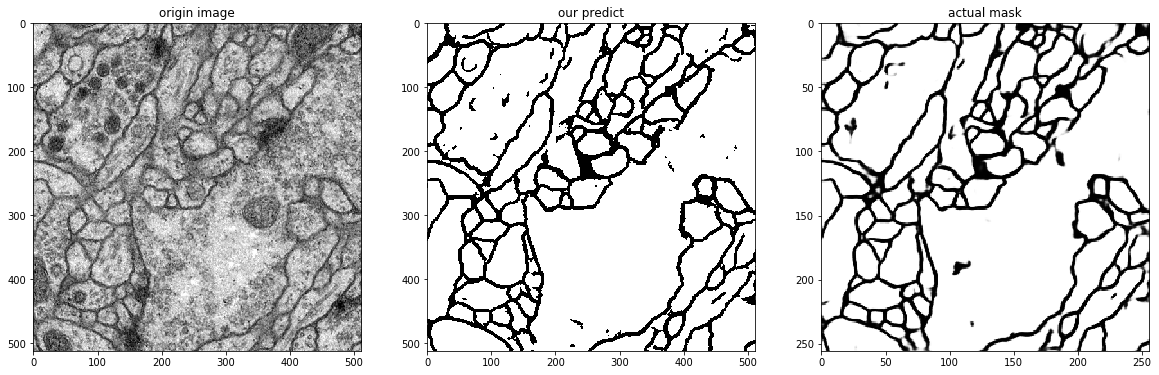

In [33]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

def predict_image(model,image):
  origin_shape=image.shape
  mask_image=np.empty((origin_shape[0],origin_shape[1],2))
  image=image/255
  #填充图像，以对应网络的边缘损失
  image=np.pad(image,((92,92),(92,92)),'symmetric')
  #原始图像按388大小切块
  row_block_count=origin_shape[0]//388+1
  col_block_count=origin_shape[1]//388+1
  block_positions=[]#记录388块的左上角位置
  for row in range(row_block_count):
    for col in range(col_block_count):
      if row == row_block_count-1 and col==col_block_count-1:
        block=(origin_shape[0]-388,origin_shape[1]-388)
        block_positions.append(block)
      elif row == row_block_count-1:
        block=(origin_shape[0]-388,col*388)
        block_positions.append(block)
      elif col==col_block_count-1:
        block=(row*388,origin_shape[1]-388)
        block_positions.append(block)
      else:
        block=(row*388,col*388)
        block_positions.append(block)
  #对每个区域进行检测，然后将结果填到对应的mask位置
  for position in block_positions:
    image_block=image[position[0]:position[0]+572,position[1]:position[1]+572]
    image_block=image_block.reshape((1,572,572,1))
    mask_block=model.predict(image_block,batch_size=1)
    mask_image[position[0]:position[0]+388,position[1]:position[1]+388,:]=mask_block
  mask_cell=mask_image[:,:,0]>mask_image[:,:,1]
  mask_cell=mask_cell.astype(np.uint8)*255
  return mask_cell

model=unet('/content/drive/My Drive/unet_membrane.hdf5')
image=io.imread('/content/unet-data/test/0.png')
mask_image=predict_image(model,image)
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.title('origin image')
plt.imshow(image,cmap ='gray')
plt.subplot(1,3,2)
plt.title('our predict')
plt.imshow(mask_image,cmap ='gray')
plt.subplot(1,3,3)
plt.title('actual mask')
test_predict=io.imread('/content/unet-data/test/0_predict.png')
plt.imshow(test_predict,cmap ='gray')
plt.show()